In [1]:
from pathlib import Path
import os
workdir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/")
print(workdir)
os.chdir(workdir)
current_working_dir = Path.cwd()
print(f"Current working directory is now: {current_working_dir}")

/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG
Current working directory is now: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
import sys

In [3]:
# === PATHS ===
workdir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/")
script_dir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Python_Code_Analysis/DL_Learning")
sys.path.insert(0, str(script_dir))

from _04_dataset import WetlandDataset
from _05_unet_model import UNet

/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG
Current working directory is now: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG
/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG
Current working directory is now: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG
Class distribution:
  Class 0: 19,837,679 pixels (85.99%)
  Class 1: 527,896 pixels (2.29%)
  Class 2: 1,357,839 pixels (5.89%)
  Class 3: 1,157,860 pixels (5.02%)
  Class 4: 187,398 pixels (0.81%)

Class weights (inverse frequency):
  Background: 1.00
  EMW: 37.58
  FSW: 14.61
  SSW: 17.13
  OWW: 105.86


In [5]:
# === LOAD MODEL ===
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if 
                          torch.backends.mps.is_available() else "cpu")
model = UNet(in_channels=12, num_classes=5, base_filters=32)

checkpoint = torch.load(workdir / "Models/final_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch'] + 1}")
print(f"Validation loss: {checkpoint['val_loss']:.4f}")
print(f"Validation accuracy: {checkpoint['val_acc']:.4f}")

Loaded model from epoch 26
Validation loss: 0.9797
Validation accuracy: 0.6076


In [6]:
# === LOAD VALIDATION DATA ===
val_dataset = WetlandDataset(
    workdir / "Data/Patches_v2/X_val.npy",
    workdir / "Data/Patches_v2/y_val.npy",
    normalize=True
)

In [7]:
# === VISUALIZATION SETUP ===
class_names = ['Background', 'EMW', 'FSW', 'SSW', 'OWW']
colors = ['white', 'green', 'darkgreen', 'orange', 'blue']
cmap = ListedColormap(colors)

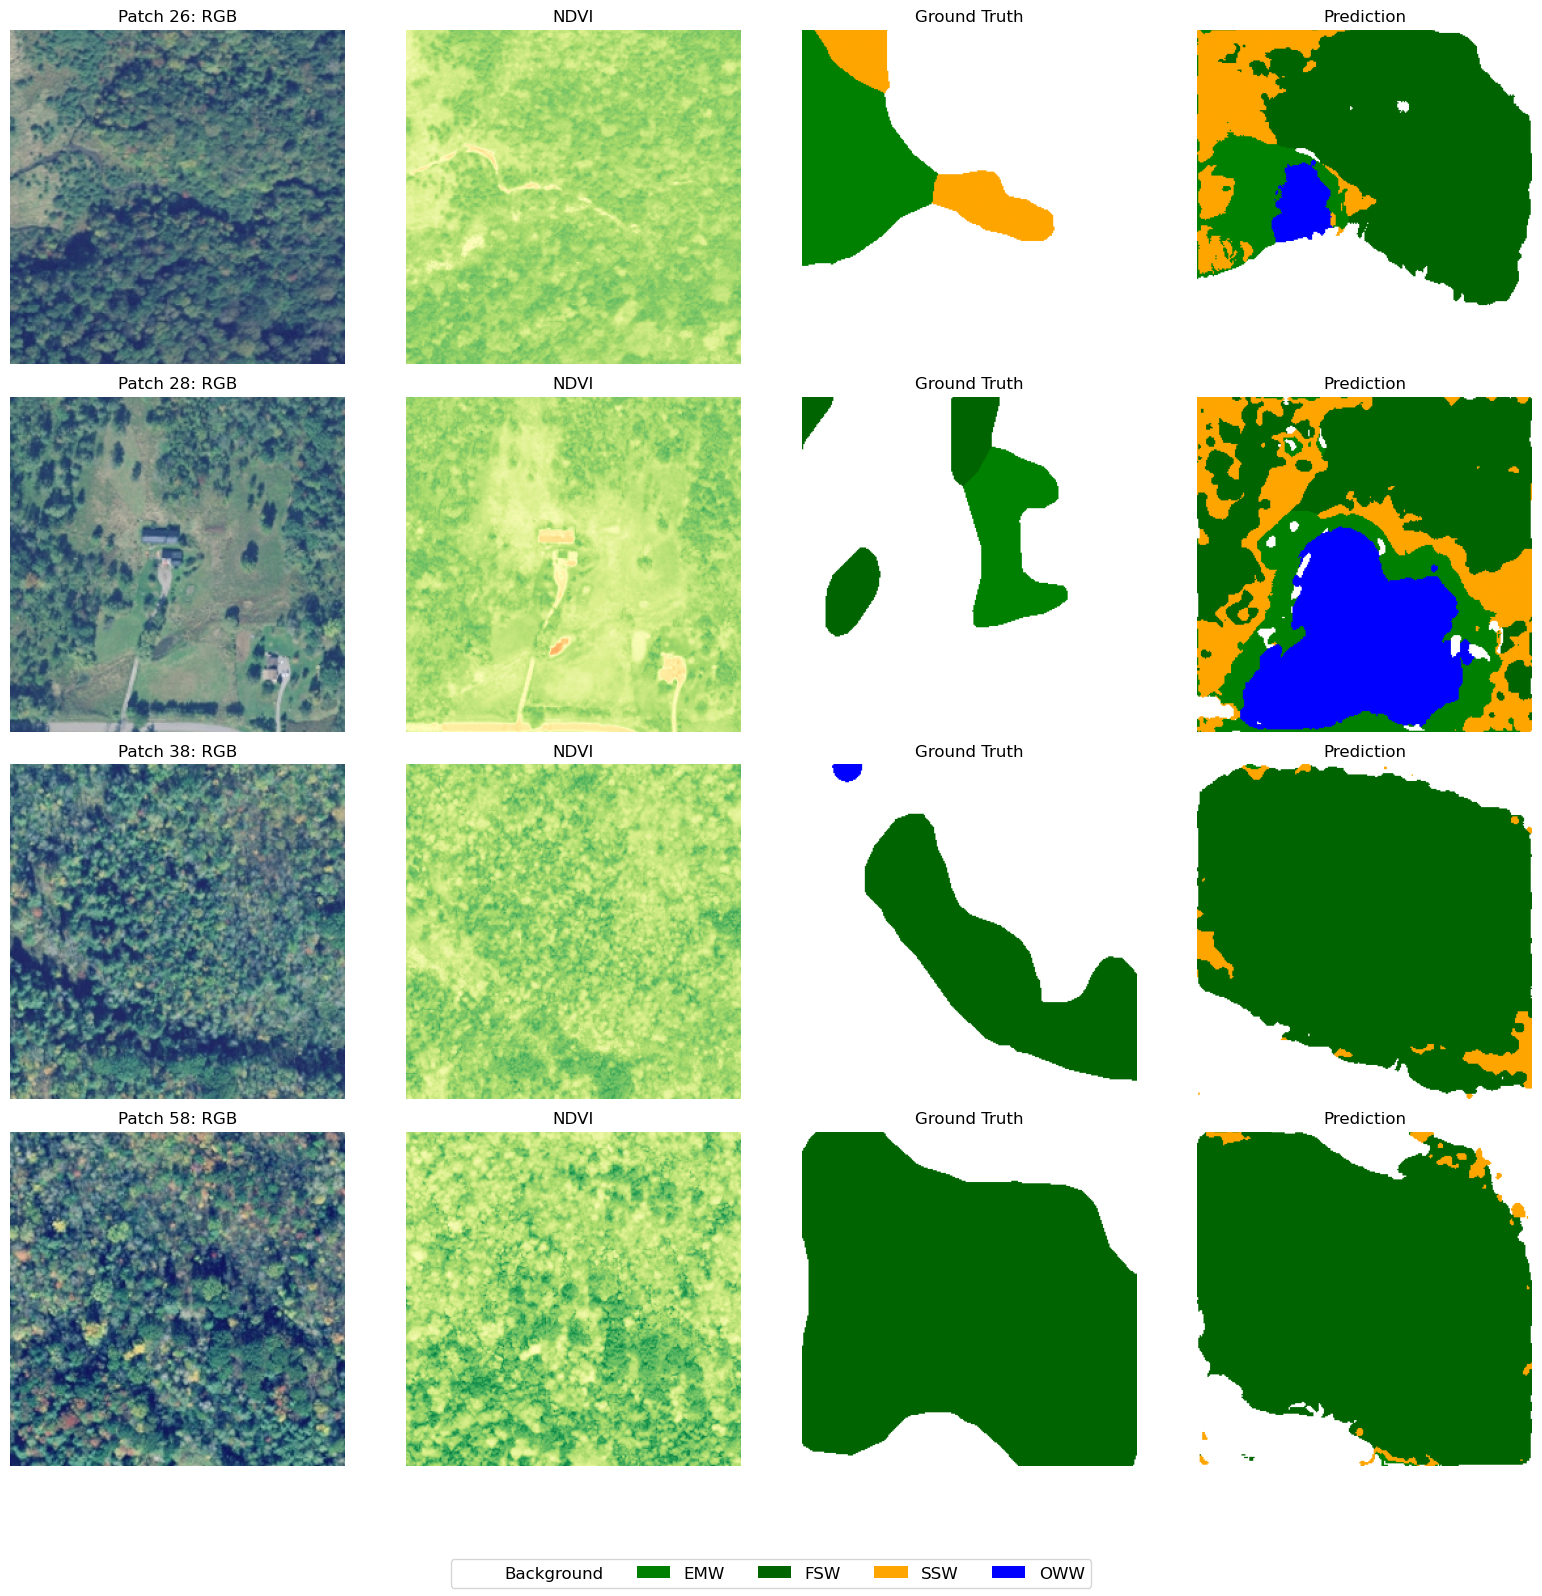


Saved visualization to Models/prediction_samples.png


In [12]:
# === PLOT SAMPLE PREDICTIONS ===
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Select 4 random validation patches
np.random.seed(11)
indices = np.random.choice(len(val_dataset), 4, replace=False)
# print(indices)
for row, idx in enumerate(indices):
    X, y_true = val_dataset[idx]
    
    # Get prediction
    with torch.no_grad():
        output = model(X.unsqueeze(0))  # Add batch dimension
        y_pred = torch.argmax(output, dim=1).squeeze().numpy()
    
    # Convert tensors to numpy for plotting
    y_true = y_true.numpy()
    
    # RGB image (denormalize)
    rgb = X[0:3].numpy().transpose(1, 2, 0)  # Already 0-1 from normalization
    
    # Plot RGB
    axes[row, 0].imshow(rgb)
    axes[row, 0].set_title(f"Patch {idx}: RGB")
    axes[row, 0].axis('off')
    
    # Plot NDVI
    ndvi = X[4].numpy()
    axes[row, 1].imshow(ndvi, cmap='RdYlGn', vmin=0, vmax=1)
    axes[row, 1].set_title("NDVI")
    axes[row, 1].axis('off')
    
    # Plot ground truth
    axes[row, 2].imshow(y_true, cmap=cmap, vmin=0, vmax=4)
    axes[row, 2].set_title("Ground Truth")
    axes[row, 2].axis('off')
    
    # Plot prediction
    axes[row, 3].imshow(y_pred, cmap=cmap, vmin=0, vmax=4)
    axes[row, 3].set_title("Prediction")
    axes[row, 3].axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=n) for c, n in zip(colors, class_names)]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.savefig(workdir / "Models/prediction_samples.png", dpi=150)
plt.show()

print(f"\nSaved visualization to Models/prediction_samples.png")